In [460]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 25)
from scipy.stats import chi2_contingency


#### Biodiversity Project

This project will analyze data from two files: observations.csv and species_info.csv

`Observations.csv` compiles information about the scientific names of a species, the number of observations of that species in the past 7 days, and the park where the observations occurred. Variables:
- **scientific_name**
- **park_name**
- **observations**

`Species_info.csv` compiles information about all the different scientific names for species, the common names for these species, the category of the species, and the conservation status of the species. Variables:
- **category**
- **scientific_name**
- **common_names**
- **conservation_status**



In [39]:
#Printing the shape of the dataset shows thast it has just under 6,000 rows and 4 columns.
species = pd.read_csv('/users/ghanimsial/desktop/Code Cademy/Data Science Machine Learning Specialist/Biodiversity Project/species_info.csv')
print(f'Shape of species: {species.shape}')
species.fillna(value = {'conservation_status': 'no intervention'}, inplace=True)
species.head()
# category
# scientific_name
# common_names
# conservation_status



Shape of species: (5824, 4)


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,no intervention
1,Mammal,Bos bison,"American Bison, Bison",no intervention
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",no intervention
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",no intervention
4,Mammal,Cervus elaphus,Wapiti Or Elk,no intervention


In [12]:
#Printing the shape of the dataset reveals that it has over 23,000 rows and 3 columns.
observations = pd.read_csv('/users/ghanimsial/desktop/Code Cademy/Data Science Machine Learning Specialist/Biodiversity Project/observations.csv')
print(f'Shape of observations: {observations.shape}')
observations.head()
# scientific_name
# park_name
# observations

Shape of observations: (23296, 3)


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


#### Objectives
- **Distribution of conservation_status across category**
- **Are certain types of species more likely to be endangered as compared to others?**
- **Which animal is comprised of the greatest number of species and what is its observations distribution across parks?**
- **Are the differences between species and their conservation status significant?**


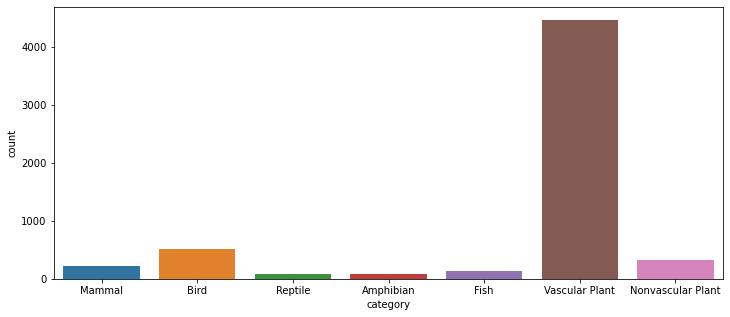

In [480]:
#A graph depicting the count of each category in the species dataset
#Vascular plants are the largest category in this dataset with over 4000 species.
species.conservation_status.unique()
plt.figure(figsize = (12,5))
ax = sns.countplot(data = species, x = species.category)

5541

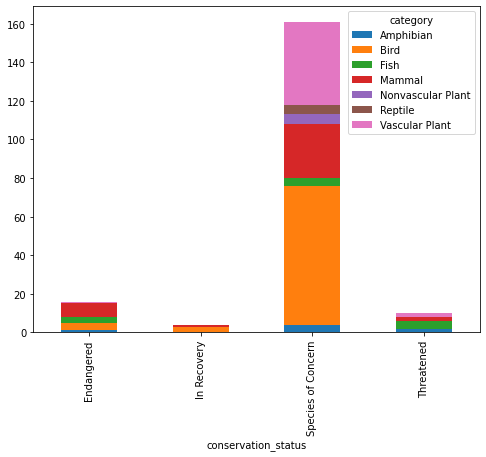

In [58]:
#A graph to depict distribution of categories across conservation status.
#Birds make up the greatest species of concern, and mammals make up the greatest portion of endangered animals.
cat_cons = species[species['conservation_status'] != 'no intervention'].groupby(['conservation_status', 'category']).scientific_name.count().unstack()
cat_cons.plot(kind = 'bar', stacked = True, figsize = (8,6))


In [118]:
#Created a table to show the protected percentage across each category.
#Although both birds and vascular plants have more protected species than mammals, it is due to their larger population/species count. As a proportion, mammals have the greatest proportion of protected species.
species['is_protected'] = species['conservation_status'] != 'no intervention'
category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns = 'is_protected', index = 'category', values = 'scientific_name').reset_index()
category_counts.columns = ['category', 'not protected', 'protected']
category_counts['protection_percentage'] = np.round(100*category_counts.protected/(category_counts['not protected']+category_counts.protected), 2)
category_counts


,category,not protected,protected,protection_percentage
0,Amphibian,72,7,8.86
1,Bird,413,75,15.37
2,Fish,115,11,8.73
3,Mammal,146,30,17.05
4,Nonvascular Plant,328,5,1.50
5,Reptile,73,5,6.41
6,Vascular Plant,4216,46,1.08


In [486]:
#Using the chi2_contingency function from the scipy.stats library to conduct a chi squared analysis of mammals against birds to see if there are any significant differences between species and their conservation status.
species['is_protected'] = species['conservation_status'] != 'no intervention'
mammal_bird = [[30, 146], [75, 413]]
results = chi2_contingency(mammal_bird)
print(f'Mammals Vs. Birds\nP-Value: {results[1]} \nChi Statistic:{results[0]}')
# The p-value is statistically insignificant suggesting the two variables are independent
#The chi squared statistic is also small suggesting no associativity.



Mammals Vs. Birds
P-Value: 0.6875948096661336 
Chi Statistic:0.1617014831654557


In [153]:
#Another chi-squared analysis but this time it is reptiles againts mammals.
species['is_protected'] = species['conservation_status'] != 'no intervention'
category_counts2 = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns = 'is_protected', index = 'category', values = 'scientific_name').reset_index()
category_counts2.columns = ['category', 'not protected', 'protected']
reptile_mammal = [[5, 73], [30, 146]]
results = chi2_contingency(reptile_mammal)
print(f'Reptile vs. Mammal\nP-Value: {results[1]} \nChi Statistic:{results[0]}')
#The P-value is statistically significant at the 5% level and a chi statistic of 4.28 suggest associativity meaning that mammals are statistically more likely to need protection as compared to reptiles.

(4.289183096203645, 0.03835559022969898, 1, array([[ 10.7480315,  67.2519685],
       [ 24.2519685, 151.7480315]]))
Reptile vs. Mammal
P-Value: 0.03835559022969898 
Chi Statistic:4.289183096203645


In [471]:
#The below functions and code blocks first takes the section of the species dataset pertaining to mammals.
#It then removes all the punctuation from the common names column after which it delete duplicates. It then crestes a count for each word to see which words show up the most.
#Afterwards it compiles the list from a zipped list of paired-values to a datagrame with the words and counts as two columns. We determine that from the mammalian species, bats are the most common species.

data = species[species.category == 'Mammal']
punctuation = [',', "'", '(', ')', '.', '-']
def remove_punctuation(text):
    for i in punctuation:
        text = text.replace(i, '')
    return text
empty_dict = {}
empty_list = []

data.common_names = data.common_names.apply(remove_punctuation)
for i in data.common_names:
    i = i.split()
    i = list(dict.fromkeys(i))
    for y in i:
        if y in empty_dict:
            empty_dict[y] +=1
        else:
            empty_dict[y] = 1
listy = list(zip(empty_dict.keys(), empty_dict.values()))
listy = pd.DataFrame(listy)
listy.sort_values(by = 1, ascending = False)

/var/folders/cn/qrzvtdnd3wg0270pcwylrl5m0000gn/T/ipykernel_58304/2995702985.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.common_names = data.common_names.apply(remove_punctuation)


,0,1
51,Bat,23
110,Shrew,18
57,Myotis,17
88,Mouse,16
107,Chipmunk,13
...,...,...
101,House,1
98,Stones,1
94,WhiteFooted,1
93,Cotton,1


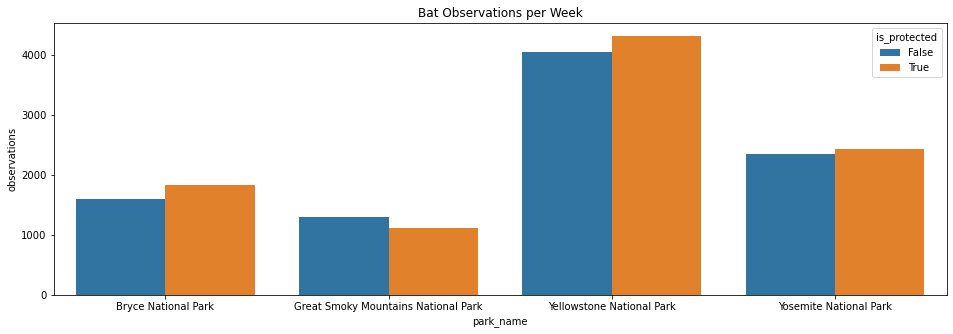

In [452]:
#We then create a special column in the dataset specifically as a indicator of if the species is a species of bat using the str.contain method and a regex statement.
#Afterwards we aggregate bat observations along parks after merging the species and observations dataset together. At the bottom is a graph of observed protected vs. not protected species of bats across parks.
species['is_bat'] = species.common_names.str.contains(r'\bBat\b', regex = True)
bat_observations = species[species.is_bat == True]
bat_observations = bat_observations.merge(observations, on = 'scientific_name')
bat_prot_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
bat_prot_by_park.columns = ['park_name', 'is_protected', 'observations']
plt.figure(figsize = (16,5))
sns.barplot(data = bat_prot_by_park, x = 'park_name', y = 'observations', hue = 'is_protected')
plt.title('Bat Observations per Week')
plt.show()


In [470]:
# A list of species that are protected from the species dataset.
merger = observations.merge(species, on = 'scientific_name')
protected = merger[merger.is_protected == True]

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
122,Zizia trifoliata,Bryce National Park,87,Vascular Plant,"Meadow Alexanders, Three-Leaved Golden Alexanders",Species of Concern,True,False
204,Camissonia sierrae ssp. alticola,Bryce National Park,84,Vascular Plant,"Mono Hot Springs Evening Primrose, Mono Hot Sp...",Species of Concern,True,False
378,Tofieldia glabra,Bryce National Park,70,Vascular Plant,"Smooth Bog-Asphodel, Smooth Tofieldia",Species of Concern,True,False
512,Accipiter cooperii,Bryce National Park,95,Bird,Cooper's Hawk,Species of Concern,True,False
622,Dichanthelium acuminatum var. acuminatum,Bryce National Park,87,Vascular Plant,Tapered Rosette Grass,Species of Concern,True,False
...,...,...,...,...,...,...,...,...
24749,Sorex preblei,Bryce National Park,71,Mammal,"Malheur Shrew, Preble's Shrew",Species of Concern,True,False
24901,Chlidonias niger,Bryce National Park,105,Bird,Black Tern,Species of Concern,True,False
24970,Progne subis,Bryce National Park,82,Bird,Purple Martin,Species of Concern,True,False
25270,Lophocolea appalachiana,Bryce National Park,81,Nonvascular Plant,Appalachian Lophocolea,Species of Concern,True,False


In [472]:
data = species[species.category == 'Bird']
punctuation = [',', "'", '(', ')', '.', '-']
def remove_punctuation(text):
    for i in punctuation:
        text = text.replace(i, '')
    return text
empty_dict = {}
empty_list = []

data.common_names = data.common_names.apply(remove_punctuation)
for i in data.common_names:
    i = i.split()
    i = list(dict.fromkeys(i))
    for y in i:
        if y in empty_dict:
            empty_dict[y] +=1
        else:
            empty_dict[y] = 1
listy = list(zip(empty_dict.keys(), empty_dict.values()))
listy = pd.DataFrame(listy)
listy.sort_values(by = 1, ascending = False)

/var/folders/cn/qrzvtdnd3wg0270pcwylrl5m0000gn/T/ipykernel_58304/1971320527.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.common_names = data.common_names.apply(remove_punctuation)


,0,1
1,Warbler,59
138,Sparrow,29
13,American,21
4,Northern,20
298,Owl,18
...,...,...
287,RedHeaded,1
288,RedCockaded,1
289,Downy,1
290,Hairy,1


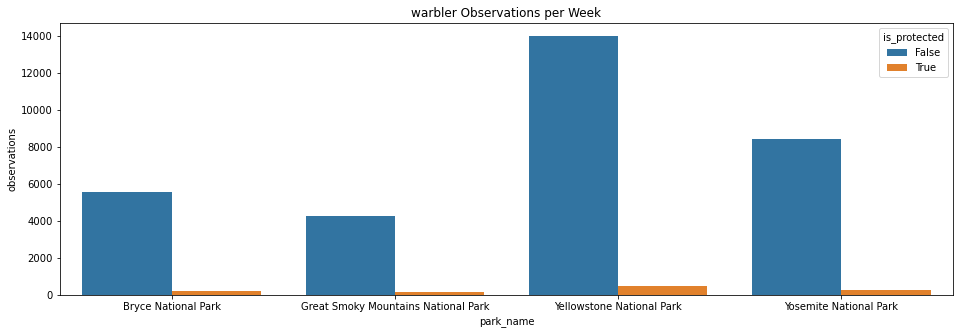

In [473]:
species['is_warbler'] = species.common_names.str.contains(r'\bWarbler\b', regex = True)
warbler_observations = species[species.is_warbler == True]
warbler_observations = warbler_observations.merge(observations, on = 'scientific_name')
warbler_prot_by_park = warbler_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
warbler_prot_by_park.columns = ['park_name', 'is_protected', 'observations']
plt.figure(figsize = (16,5))
sns.barplot(data = warbler_prot_by_park, x = 'park_name', y = 'observations', hue = 'is_protected')
plt.title('Warbler Observations per Week')
plt.show()

#### Conclusions
- Distribution of conservation_status across category
- - Mammals make up the greatest portion of endangerd species, and birds make up the greatest portion of species of concern
- Are certain types of species more likely to be endangered as compared to others?
- - Mammals and birds have the highest percentage of protected species in their total species pool. Although categories like vascular plants have a large number of protected species, as a proportion it is relatively small.
- Which animal is comprised of the greatest number of species and what is its observations distribution across parks?
- - Bats comprised the grestest number of mammalian species, and warblers comprised the grestest number of bird species. Interestingly enough, the number of protected bats across the parks is greaster than the number of non-protected bats cumulatively. However, the number of protected warblers is extremely small compared to the number of non-protected warblers.
- Are the differences between species and their conservation status significant?
- - After running tests, it seems that Mammals are more likely, as compared to reptiles, to be endangered. When mammals were compared against birds, the results were not statistically significant suggesting that the differences between the conservation status of the two are insiginificant.